In [3]:
import numpy as np
import xarray as xr
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

/home/philippotn/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_lFiles(simu):
    # userPath = '/cnrm/tropics/user/philippotn'
    userPath = '/home/philippotn'

    if userPath == '/home/philippotn':
        dataPath = userPath+'/Documents/SIMU_LES/'
    else:
        dataPath = userPath+'/LES_'+simu+'/NO_SAVE/'

    if simu == 'AMOPL':
        seg = 'M200m'# ; lFiles = [dataPath + 'AMOPL.1.200m1.OUT.{:03d}.nc'.format(i) for i in range(1,241,1)] + [dataPath + 'AMOPL.1.200m2.OUT.{:03d}.nc'.format(i) for i in range(1,722,1)]
        lFiles = [dataPath + 'AMOPL.1.200m1.OUT.{:03d}.nc'.format(i) for i in [60,120,180,240,241]]+[dataPath + 'AMOPL.1.200m2.OUT.{:03d}.nc'.format(i) for i in [60,120,180,240,300,360,420,480,540,600,660,720]]
    elif simu== 'A0W0V':
        seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,60)]
    elif simu== 'ATRI2':
        seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,60)]
    elif simu== 'ACON2':
        seg = 'S200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,962,1)]
    elif simu== 'AMO20':
        seg = 'M200m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in [1,61,121,181,241,301,361,421,481,541,601,661,699]]#range(1,961,1)]
    elif simu== 'CTRI2':
        seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,872,1)]
    elif simu== 'CFLAT':
        seg = 'S100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(1,872,1)]
    elif simu== 'CMO10':
        seg = 'M100m' ; lFiles = [dataPath + simu+'.1.'+seg+'.OUT.{:03d}.nc'.format(i) for i in range(2,3,1)]
    
    file_mean = dataPath+simu+'_'+seg+'_mean.nc'
    return lFiles , file_mean



def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 50, fill = '█', printEnd = "\r"):
    ratio = str(iteration)+' / '+str(total)
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {ratio} {suffix}', end = printEnd)
    if iteration == total: # Print New Line on Complete
        print()

In [5]:
def spectrum2D(data2D):
    _,nx = np.shape(data2D)
    fourier_image = np.fft.fftn(data2D)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(nx)*nx
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, nx//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    # Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    Abins *= 2*np.pi * kvals
    return nx/kvals,Abins/nx**2#2*np.sqrt(Abins)/nx**2#Abins#

Text(0.5, 0.98, 'Surface wind spectrums')

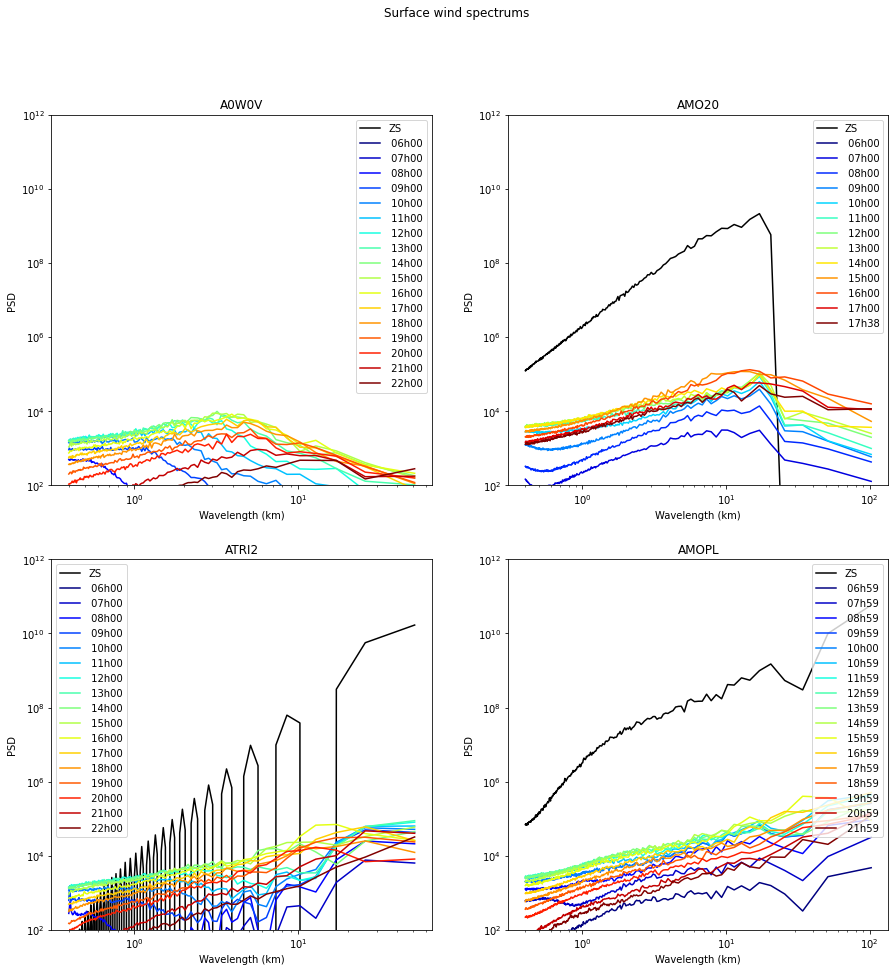

In [11]:
#%% mean spectrum per small group
les_simu = ['A0W0V','AMO20','ATRI2','AMOPL']#
fig,axs= plt.subplots(nrows=2,ncols=2,figsize=(15,15))
for i,simu in enumerate(les_simu):
    #ax = axs[i]
    ax = axs[i//2,i%2]
    lFiles , file_mean = get_lFiles(simu)
    
    fmean = xr.open_dataset(file_mean)
    ZS = fmean['ZS'].data
    
    f0 = xr.open_dataset(lFiles[0])

    nx1 = 1 ; nx2 = len(f0.ni)-1
    ny1 = 1 ; ny2 = len(f0.nj)-1
    nz1 = 1 ; nz2 = len(f0.level)

    x = np.array(f0.ni)[nx1:nx2]
    y = np.array(f0.nj)[ny1:ny2]
    z = np.array(f0.level)[nz1:nz2]
    z_ = np.array(f0.level_w)[nz1:nz2]
    dz = z_[1:]-z_[:-1]
    dz = np.append(dz,dz[-1])

    dx = x[1]-x[0]
    nt,nz,ny,nx = len(lFiles),len(z),len(y),len(x)

    l,P = spectrum2D(ZS)
    ax.loglog(dx*l/1000, P,color='k',label='ZS')
    ax.set_xlabel("Wavelength (km)")
    ax.set_ylabel("PSD")
    ax.set_ylim([1e2,1e12])
    
    cmap = matplotlib.cm.get_cmap('jet')
    colors = cmap(np.linspace(0,1,nt))

    for it,fname in enumerate(lFiles):
        f = xr.open_dataset(fname)
        US = f['UT'][0,nz1,ny1:ny2,nx1:nx2].data
        VS = f['VT'][0,nz1,ny1:ny2,nx1:nx2].data
        
        l,P = spectrum2D(US + 1j*VS)
        label = ' {:02d}h{:02d}'.format(int(f.time.dt.hour),int(f.time.dt.minute)) #) # year = str(f.time.data[0])[:10]+

        ax.loglog(dx*l/1000, P,color=colors[it],label=label)
        
    ax.set_title( simu)
    ax.legend()
fig.suptitle('Surface wind spectrums')
#fig.savefig(savePath+simu+"_w_spectrum_all.png", dpi = 300, bbox_inches = "tight")